<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/rl.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Reinforcement Learning (RL)
---
_homl3 ch18_

- RL is one of the most exciting fields of ML and also one of the oldest
- RL achievements after applied deep learning (DL)
  - In 2013, DeepMind demonstrated a system that [outperforms humans](https://homl.info/dqn2) in most of [Atari game](https://homl.info/dqn) by learning from scratch 
    - using only raw pixels as inputs and without any prior knowledge of the rules of the games
  - Google `AlphaGo` beat a legendary professional player of the game of Go Lee Sedol in March 2016
    - then beat the world champion Ke Jie in May 2017
    - later evolved into [AlphaZero and MuZero](https://deepmind.google/technologies/alphazero-and-muzero/)
- Two of the most important techniques in deep reinforcement learning (DRL):
  - `policy gradients` and `deep Q-networks`

In [1]:
# Colab: Go to Runtime > Change runtime and select a GPU hardware
# Kaggle: Go to Settings > Accelerator and select GPU
# ⚠️ It may take more than one day to run the whole notebook without GPU
import sys, os, math, copy
from pathlib import Path

if "google.colab" in sys.modules:
  %pip install -q -U gymnasium swig
  %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]
else:
  os.environ["TF_USE_LEGACY_KERAS"] = "1"
  
import gymnasium as gym
from functools import partial
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, matplotlib.animation as man
import sklearn as skl, sklearn.datasets as skds
import tensorflow as tf, tensorflow_datasets as tfds

2024-04-14 09:59:59.094792: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 09:59:59.193413: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 09:59:59.567330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 10:00:00.672895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


💡 Demo
---
- DeepMind algorithm exceeds in game [breakout](https://youtu.be/Q70ulPJW3Gk)
- [Google's AI AlphaGo Is Beating Humanity At Its Own Games](https://youtu.be/8dMFJpEGNLQ)

🎥 Watch by yourself
---
- [Google's Deep Mind Explained! - Self Learning A.I.](https://youtu.be/TnUYcTuZJpM)
- [Europe's FIRST Autonomous Robot Delivery Fleet](https://youtu.be/vVPK6o7gebI)

What is RL?
---
In RL,
- a `software agent` makes `observations` and takes `actions` within an `environment`
  - in return it receives `rewards` from the environment
- Its `objective` is to `learn to act in a way` that will `maximize` its `expected rewards over time`

In short, RL is learning to `optimize rewards`.

❓ Questions
---
In the following RL (p1), what are the `observations`, `actions`, `environment` and `rewards`?

How a software agent determines its actions?
---
- through a algorithm called `policy` that could be
  - (p2) a `neural network` taking observations as inputs and outputting the action to take
  - deterministic or `stochastic`

🍎 Example
---
Consider a `robotic vacuum cleaner` whose `reward` is the `amount of dust` it picks up in T minutes. 
- Its policy could be to
  - move forward with some `probability p` every second
  - or randomly rotate left or right with probability 1 – p
    - The rotation angle would be a `random angle` between –r and +r
- (p3) The robot will have an erratic trajectory
  - which guarantees that it will eventually get to any place it can reach and pick up all the dust
- The questions are
  - ❶ How much dust will it pick up in T minutes?
  - ❷ How would you train such a robot?
- Solution
  - ❶ build up the `physical models` of the agents, environment, and the dust picking process
  - ❷ determine the tunable `policy parameters` at every step: the probability p and the angle range r
    - and the `policy space`: P×R is the Cartesian product of the range P of p and the range R of r
  - training the robot is the procedure of searching the best parameter sequences (p₀,r₀), (p₁,r₁), ⋯, (pₙ,rₙ) that maximize the rewards, i.e. minimize the time spent to collect all dust
    - this procedure is called `policy search`
- Algorithms for policy search
  - brute-force, divide-and-conquer, dynamic programming, backtracking, genetic algorithm, etc.
  - `policy gradients (PG)`, like gradient decent, 
    - evaluates the `gradients of the rewards with regard to the policy parameters`, 
    - then tweaks these parameters by following the gradients toward higher rewards

A simulated environment - [Gymnasium](https://gymnasium.farama.org/)
---
- a toolkit that provides a wide variety of simulated environments such as
  - Atari games, board games, 2D and 3D physical simulations, and so on
  - can be used to train agents, compare them, or develop new RL algorithms
- needs installation on Colab
  ```python
  %pip install -q -U gymnasium swig
  %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]
  ``` 
- the environments needed in this notebook
  - classic_control: a classic environments from control theory
    - the science of controlling dynamical systems
    - such as balancing a pole on a cart
  - box2d: a 2D physics engine for games
  - atari: the Arcade Learning Environment (ALE)
    - wan emulator for Atari 2600 games. Several Atari game ROMs are downloaded automatically
  - accept-rom-license: the Atari’s ROM licenses needed to run atari

💡 Demo
---
- (p4) Create a new CartPole environment
  - composed of a cart that can move left or right
  - and a pole placed vertically on top of it
- The agent must move the cart left or right to keep the pole upright
  - as long as possible

In [2]:
# 0. list all available environments
# 1) here show only the first 5
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', '...']

In [3]:
# 2) shows the specification for the CartPole-v1 environment
# The registry values are environment specifications:
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [4]:
# 1. Create the CartPole (version 1) environment
# 
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [5]:
# 2. initialize the environment by calling its `reset()` method which returns
# a) an observation: a 1D NumPy array composed of 4 floats: 
# ➀ the cart's `horizontal position x`, 0.0 = center
# ➁ its `velocity v`, positive means right
# ➂ the `angle of the pole θ`, 0 = vertical, 
# ➃and the `angular velocity ω`, positive means clockwise
# 
# b) a dictionary that may contain extra information. 
# 🏃 describe the observation 
obs, info = env.reset(seed=2025)
obs, info

(array([ 0.04944578, -0.01179903,  0.0327148 ,  0.03372553], dtype=float32),
 {})

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


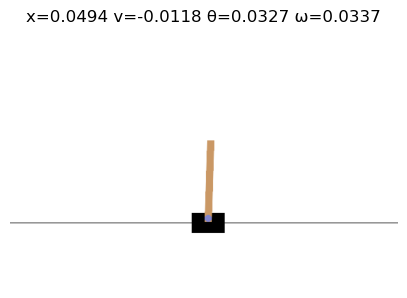

In [6]:
# 3. visualize the environment
img = env.render()

def plot_environment(env, obs, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    title = f"x={obs[0]:.4f} v={obs[1]:.4f} θ={obs[2]:.4f} ω={obs[3]:.4f}"
    plt.title(title)
    plt.axis("off")
    return img

plot_environment(env,obs);

In [7]:
# 4. find possible actions
# two possible actions here: 
# accelerate towards the left (0) or towards the right (1).
env.action_space

Discrete(2)

- The `learning procedure` is carried out by the environment's `step()` method which returns
  - `obs`: the new observation
  - `reward`: equals 1.0 at every step in CartPole environment no matter what you do
    - so the goal is to keep the `episode` running for as long as possible
    - An `episode` is the sequence of steps between the moment the environment is reset until it is done or truncated
  - `done`: True when the episode is over. 
    - This will happen when
      - the pole tilts too much, 
      - or goes off the screen, 
      - or after 200 steps (in this case, you have won)
    - After that, the environment must be reset before it can be used again
  - `truncated`:  True when an episode is interrupted early
    - e.x. by an environment wrapper that imposes a maximum number of steps per episode
    - Some RL algorithms treat truncated episodes differently from episodes finished normally
      - we will treat them identically here
  - `info`: extra information, just like the one returned by the reset() method
    - useful for debugging or for training
    - ex, in some games it may indicate how many lives the agent has

In [8]:
# 5. interact with the environment by selecting an action
# Since the pole is leaning toward the right (`θ > 0`), 
# let's accelerate the cart toward the right:
#
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)

# 🏃 describe the observation again
(obs, reward, done, truncated, info)

(array([ 0.0492098 ,  0.18283889,  0.03338931, -0.24845868], dtype=float32),
 1.0,
 False,
 False,
 {})

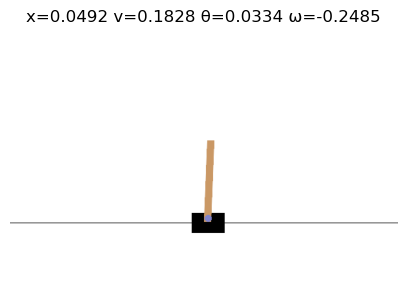

In [9]:
plot_environment(env, obs);

In [10]:
# 6. reset the environment
# At the end of an episode i.e., 
# when `step()` returns `done=True` or `truncated=True`
# you should reset the environment before you continue to use it

if done or truncated:
    obs, info = env.reset()

A simple hard-coded policy
---
- if the pole is tilting to the left, then push the cart to the left, and _vice versa_
- A `policy` is the strategy that the agent will use to select an action at each step
  - It can use all the past actions and observations to decide what to do

In [11]:
# 1. hard-code a simple policy
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500): # try 500 times
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [12]:
# 2. show the results for the 500 tries
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

- Among the 500 tries, the best this policy did was to keep the poll up for only 63 steps
- In the following simulation, the cart oscillates left and right more and more strongly until the pole tilts too much

In [13]:
# 3. Animate one episode
#
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = man.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy);

/opt/micromamba/envs/ml/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Neural Network Policies
---
- (p5) take an observation as input and output the action to be executed
- estimate a `probability` for each action
  - then select an action randomly according to the estimated probabilities
- In the CartPole environment, one output neuron will output 
  - the probability `p` of action 0 (left)
  - the probability `1 – p` of action 1 (right)
- Picking a random action based on the probabilities given by the neural network rather than just picking the action with the highest score is called the `exploration/exploitation dilemma`
  - This approach lets the agent find the right `balance` between `exploring new actions` and `exploiting the actions` that are known to work well
  - ex. think about `exploring new scenery spots` and `visiting known scenery spots`
- The past actions and observations can be 
  - ignored if each observation contains the environment’s `full state`
    - such as in the case of the CartPole
  - helpful and considered if there were some hidden state or the observations were noisy

In [14]:
# 1. build a neural network policy
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [15]:
# 2. get the probability of moving left with this nn
# and run one episode
# the result will be very bad since the nn is not trained yet
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

show_one_episode(pg_policy);

Evaluating Actions: The Credit Assignment Problem
---
- Action effect needs to be evaluated before training the nn
- It is a challenge to evaluate action effect since most actions have `delayed` effects
  - this is called the `credit assignment problem`
- (p6) A common strategy to this problem is to evaluate an action based on the sum of all the rewards that come after it
  - usually applying a `discount factor γ` at each step
    - typical discount factors vary from 0.9 to 0.99
  - this `sum of discounted rewards` is called the action’s `return`
  - ex. in (p6) the return of the first action is: 10 + γ ×0 + γ2 × (–50) = –22
- `Action advantage` estimates how better or worse an action is compared to the other possible actions on average 
  - by running many episodes and normalizing all the action returns 
  - then subtracting the mean and dividing by the standard deviation
- On average good actions will get a higher return than bad ones

A Policy Gradients - [REINFORCE](https://homl.info/132)
---
- ➀ Play the game several times with the neural network policy
  - and at each step, compute the gradients that would make the chosen action even more likely
- ➁ Compute each action’s advantage after several episodes
- ➂ Multiply each gradient vector by the corresponding action’s advantage
  - so the gradients with positive action advantage make the action even more likely to be chosen in the future
  - and gradients with negative action advantage make this action less likely to be chosen in the future
- ➃ Compute the mean of all the resulting gradient vectors, and use it to perform a gradient descent step

In [16]:
# 1. create a function to play a single step using the model.
# 1) compute the loss and its gradients,
# save these gradients for now, and modify them later depending 
# on how good or bad the action turned out to be

def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [17]:
# 2. create another function that will rely on the `play_one_step()` function 
# to play multiple episodes, returning all the rewards and gradients, 
# for each episode and each step:

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [18]:
# 3. create couple functions for that: 
# the first will compute discounted rewards; 
# the second will normalize the discounted rewards across many episodes.

def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [19]:
# 4. create then train the nn policy
# 1) build the nn policy
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

# 2) reset the CartPole environment
obs, info = env.reset(seed=2025)

# 3) setup training
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

# 4) train the model
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 200.0

In [20]:
# 5. displays the animation with the trained nnp
show_one_episode(pg_policy);

Markov decision processes (MDPs)
---
- `PG algorithm`s directly try to optimize the policy to increase rewards
- Another popular family of algorithms based on `Markov decision processes (MDPs)` are less direct: 
  - the agent learns to `estimate the expected return` for each state, 
    - or for each action in each state
  - then it uses this knowledge to decide how to act
- `Markov chains (MCs)` is a stochastic processes with a fixed number of states
  - it randomly transits from one state to another at each step
- The probability of the transition from a state sᵢ to a state sⱼ is fixed
  - i.e depends only on the pair `(sᵢ, sⱼ)`, not on past states
  - this characteristic is also called `no memory`
- Markov chains can have very different dynamics
  - widely used in thermodynamics, chemistry, statistics, and much more
- `MDPs` resemble MCs but with a twist:
  - at each step, an agent can choose one of several possible actions
    - the transition probabilities depend on the chosen action
  - Moreover, some state transitions return some reward (positive or negative)
    - and the agent’s goal is to find a policy that will maximize reward over time

🍎 Example
---
- (p7) shows an example of a Markov chain with four states
  - s₃ is a `terminal state` which has no way out
- 🏃 describe the transitions

🍎 Example
---
- (p8) shows an example of a Markov decision process with three states
  - and up to three possible discrete actions at each step
- 🏃 What is the best action at each state?

Optimal state value equation and iteration algorithm
---
- If the agent acts optimally, the `optimal state value` ${V^*(s)}$ of any state $s$ is 
  - the `sum of all discounted future rewards` the agent can `expect on average` after it reaches the state
- equals to
  - the `reward` it will get on average after taking one optimal action
  - plus the `expected optimal value` of all possible next states that this action can lead to
- given by the recursive equation
  - ❶ ${\displaystyle V^*(s) =\max_a \sum_{s'}p(s,a,s')\left( R(s,a,s')+γV^*(s') \right) }$
  - ${ p(s,a,s') }$ is the transition probability from state s to state s′, given that the agent chose action a
  - ${ R(s, a, s′) }$ is the reward that the agent gets when it goes from state s to state s′, given that the agent chose action a
  - γ is the discount factor
- Equation ❶ leads directly to an algorithm that can precisely estimate the optimal state value of every possible state: 
  - first initialize all the state value estimates to zero 
  - then iteratively update them using the value iteration algorithm
  - ❷ ${\displaystyle ∀s:  V_{k+1}(s) ← \max_a \sum_{s'}p(s,a,s')\left( R(s,a,s')+γV_k(s') \right) }$
  - ${V_k(s)}$ is the estimated value of state s at the ${ k^{th} }$ iteration of the algorithm

State-action values — Q-values
---
- The `optimal Q-value` ${Q^*(s, a)}$ of the state-action pair (s, a) is the sum of discounted future rewards the agent can expect on average after it reaches the state s and `chooses action a`
  - but before it sees the outcome of this action and assuming it acts optimally after that action
- which can be estimated by the iteration algorithm:
  - first initialize all the Q-value estimates to zero
  - then update them using the equation given by
  - ${\displaystyle ∀(s,a): Q_{k+1}(s,a) ← \sum_{s'}p(s,a,s')\left⌊ R(s,a,s')+γ\max_{a'} Q_k(s',a') \right⌋ }$
- With the optimal Q-values, the `optimal policy` ${ π^*(s) }$ can be defined:
  - when the agent is in state s, it should choose the action with the highest Q-value for that state:
  - ${\displaystyle  π^*(s)=\underset{a}{\operatorname{argmax}}\ Q^*(s,a) }$

In [21]:
# 1. Markov chain (p7)
# run this stochastic process a few times to see what it looks like:

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

Run #1: 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #2: 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 3 
Run #4: 0 0 0 3 
Run #5: 0 0 3 
Run #6: 0 3 
Run #7: 0 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 0 0 3 
Run #9: 0 0 0 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


In [22]:
# 2. Markov Decision Process (p8)
# 1) define some transition probabilities, rewards and possible actions.
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [23]:
# 2) Q-Value Iteration
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
    
gamma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code    

In [24]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [25]:
Q_values.argmax(axis=1)  # optimal action for each state

array([0, 0, 1])

🏃 Exercise
---
- The discount factor is larger so the agent values the future more
  - it is therefore ready to pay an immediate penalty in order to get more future rewards
- Try the MDP (p8) again with a discount factor of 0.95 instead of 0.90

Temporal Difference Learning
---
- RL problems with discrete actions can often be modeled as MDPs
  - but the agent initially does not know `p(s,a,s′)` and `R(s,a,s′)`
  - It must experience each state and each transition `at least once to know the rewards`
  - and must experience them `multiple times` to have a reasonable estimate of the transition probabilities
- The `temporal difference (TD) learning algorithm` is very similar to the Q-value iteration algorithm
  - but tweaked to take into account that the agent initially knows only the possible states and actions, and nothing more
- The agent uses an `exploration policy` such as a purely random policy to explore the MDP
  - and as it progresses, the TD learning algorithm updates the estimates of the state values based on the transitions and rewards that are actually observed
- TD learning algorithm:
  - ${\displaystyle V_{k+1}(s) ← (1-α)V_k(s) + α(r+γV_k(s')) }$ or equivalently
  - ${\displaystyle V_{k+1}(s) ← V_k(s) + αδ_k(s,r,s') }$ with ${ δ_k(s,r,s')=r+γV_k(s')- V_k(s)}$
  - α is the learning rate (e.g., 0.01)
  - r + γ · Vₖ(s′) is called the TD target
  - δₖ(s, r, s′) is called the TD error
- For each state s, this algorithm keeps track of 
  - a running average of the immediate rewards the agent gets upon leaving that state
  - plus the rewards it expects to get later, assuming it acts optimally

# Q-Learning
- an adaptation of the Q-value iteration algorithm to the situation where the transition probabilities and the rewards are initially unknown
  - ${\displaystyle Q_{k+1}(s,a) ← (1-α)Q_{k}(s,a) + α(r+γ\max_{a'} Q_{k}(s',a')) }$
- works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-values 
  - Once it has accurate or close enough Q-value estimates
  - then the optimal policy is just choosing the action that has the highest Q-value
    - i.e., the `greedy policy`
- For each state-action pair `(s, a)`, this algorithm keeps track of 
  - a running average of the rewards r the agent gets upon leaving the state s with action a
  - plus the `sum of discounted future rewards` it expects to get
    - this sum is estimated to be the `maximum of the Q-value estimates for the next state s′`
    - assuming the target policy will act optimally from then on

In [26]:
# 1. implement the Q-learning algorithm
# 1) simulate an agent moving around in the environment by a step function 
# so that the agent can execute one action and get the resulting state and reward
#
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [27]:
# 2) create a policy that visits every possible state many times
# just use a random policy, since the state space is very small:
#
def exploration_policy(state):
    return np.random.choice(possible_actions[state])
  
# 3) initializes the Q-Values, just like earlier
#
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0  

In [28]:
# 3) setup running parameters
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for visualization

# then run the Q-Learning algorithm:
#  with learning rate decay using power scheduling
for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

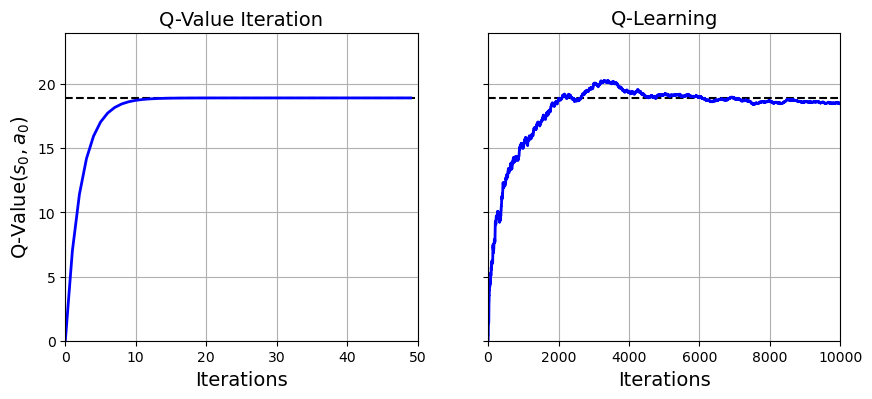

In [29]:
# 4) visualize the Q-Learning algorithm:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

plt.show()

- the Q-value iteration algorithm (left) converges very quickly, in fewer than 20 iterations
- while the Q-learning algorithm (right) takes about 8,000 iterations to converge
- Obviously, `not knowing the transition probabilities or the rewards` makes finding the optimal policy significantly harder!

Off-policy algorithm vs. on-policy algorithm
---
- The `Q-learning algorithm` is called an `off-policy algorithm` 
  - because the policy being trained (the `optimal policy`) is not necessarily 
    - the one (the completely random `exploration policy`) being used during training
  - After training, the `optimal policy` corresponds to systematically choosing the action with the highest Q-value
  - It is somewhat surprising that Q-learning is capable of learning the optimal policy by just watching an agent act randomly
- The `policy gradients algorithm` is an `on-policy algorithm`
  - it explores the world using the policy being trained

Exploration Policies
---
- Q-learning can work only if the exploration policy explores the MDP thoroughly enough
- A `purely random policy` is guaranteed to eventually visit every state and every transition many times
  - but it may take an extremely long time to achieve that
- The `ε-greedy policy` is a better option
  - at each step it acts randomly with probability ε
    - or with probability 1–ε choosing the action with the highest Q-value
  - ε starts with a high value (ex. 1.0), gradually ends with a small value (ex. 0.05)
    - thus it will spend more and more time exploring the interesting parts of the environment as the Q-value estimates get better and better
    - while still spending some time visiting unknown regions of the MDP
- Rather than relying only on chance for exploration, another approach is to 
  - encourage the exploration policy to try actions that it has not tried much before
  - This can be implemented as an exploration function added to the Q-value estimates
  - ${\displaystyle Q_{k+1}(s,a) ← (1-α)Q_{k}(s,a) + α\left(r+γ\max_{a'} f\left(Q_{k}(s',a'), N_k(s',a')\right) \right) }$
  - Nₖ(s′, a′) counts the number of times the action a′ was chosen in state s′
  - f(Q, N) is an exploration function
    - such as f(Q, N) = Q + Χ/(1 + N)
    - where Χ is a `curiosity hyperparameter` that measures how much the agent is attracted to the unknown

Approximate Q-Learning and Deep Q-Learning
---
- The main problem with Q-learning
  - it does not scale well to large or even medium MDPs with many states and actions
  - ex. There are about 150 pellets that Ms. Pac-Man can eat
    - each of which can be present or absent (i.e., already eaten). 
    - So, the number of possible states is greater than ${ 2^{150} ≈ 10^{45} }$
    - ❓How big is this number? Calculate the number of disks used to save these states if one state takes just one byte
- Solution: `approximate Q-learning`
  - find a function ${ Q_{\boldsymbol{θ}}(s, a) }$ that approximates the Q-value of any `state-action pair (s, a)`
    - using a `manageable number of parameters` given by the parameter vector ${\boldsymbol{θ}}$
- How to approximate the Q-values?
  - Historically Q-values are estimated using `linear combinations of handcrafted features` extracted from the state
    - e.g., the distances of the closest ghosts, their directions, and so on
  - Recently DNNs are used
    - such DNNs are called `deep Q-networks (DQNs)`
    - using a DQN to approximate Q-learning is called `deep Q-learning`
- How to train a DQN?
  - Get a target Q-value y(s, a) for the state-action pair (s, a) by
    - ${\displaystyle y(s,a) = r+γ\max_{a'} Q_{\boldsymbol{θ}}(s', a') }$
    - the `reward r` can be observed after playing action a in state s
    - To estimate the `sum of future discounted rewards`, we can
      - execute the DQN on the next state s′ for all possible actions a′ 
        - to get an approximate future Q-value for each possible action
      - then pick the highest and discount it
        - since the DQN is assumed to be playing optimally
  - With this target Q-value, we can run a training step using any gradient descent algorithm to minimize 
    - the `squared error` between the estimated Q-value ${ Q_{\boldsymbol{θ}}(s, a) }$ and the target Q-value ${y(s, a)}$
    - or the `Huber loss` to reduce the algorithm’s sensitivity to large errors

In [30]:
# 1. Build a Deep Q-Learning to solve the CartPole problem
# 1) In theory, we need a neural net that takes a state-action pair as input,
#     and outputs an approximate Q-value
#  In practice, it’s much more efficient to use a neural net that takes only
#     a state as input, and outputs one approximate Q-value for each possible action.
#
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
  tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
  tf.keras.layers.Dense(32, activation="elu"),
  tf.keras.layers.Dense(n_outputs)
])

In [31]:
# 2) select an action using this DQN
#    just pick the action with the largest predicted Q-value
# then use an ε-greedy policy to ensure that the agent explores the environment
#
def epsilon_greedy_policy(state, epsilon=0):
  if np.random.rand() < epsilon:
    return np.random.randint(n_outputs)  # random action
  else:
    Q_values = model.predict(state[np.newaxis], verbose=0)[0]
    return Q_values.argmax()  # optimal action according to the DQN

In [32]:
# 3) use a replay buffer to contain the agent's experiences
#   in the form of tuples: `(obs, action, reward, next_obs, done)`
#   then sample a random training batch from it at each training iteration
# This helps to reduce the correlations between the experiences in a training batch
# 
# a)  a double-ended queue (deque) can be used for small buffer
from collections import deque

replay_buffer = deque(maxlen=2000)

# b) for very large replay buffers, use a circular buffer instead 
#   as random access time will be O(1) instead of O(N)
# Or check out DeepMind's [Reverb library](https://github.com/deepmind/reverb)
# A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [33]:
# 4) create a function to sample experiences from the replay buffer
# It will return 6 NumPy arrays: 
#     `[obs, actions, rewards, next_obs, dones, truncateds]`
#
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [34]:
# 5) create a function that will use the DQN to play one step 
#   using the ε-greedy policy, 
# then store its experience in the replay buffer:
#
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info
  
  
# 6) create a function that will sample a batch of experiences 
#     from the replay buffer 
# and train the DQN by performing a single gradient descent step on this batch:
env.reset(seed=2025)
rewards = [] 
best_score = 0 

batch_size = 32
discount_factor = 0.95

optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [35]:
# 7) train the model
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for visualization, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 600, Steps: 160, eps: 0.010

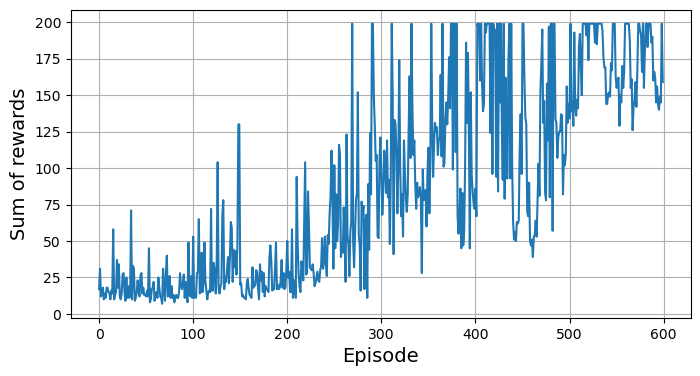

In [36]:
# 8) show the total rewards the agent got during each episode
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

- The algorithm took a while to start learning anything
  - in part because ε was very high at the beginning
- Then it bounced up and down a few times
  - and soon after it looked like it had finally stabilized near the max reward 
    - its score again dropped down dramatically 
  - This is called `catastrophic forgetting`
    - it is one of the big problems facing virtually all RL algorithms: 
      - as the agent explores the environment, it updates its policy, but what it learns in one part of the environment may break what it learned earlier in other parts of the environment
    - The experiences are quite correlated, and the learning environment keeps changing
      - this is challenging for gradient descent
    - Increasing the size of the replay buffer my help the algorithm be less subject to this problem
      - tuning the learning rate may also help
- RL is notoriously difficult: training is often `unstable` 
  - many hyperparameter values and even random seeds need to be tried 
    - before obtaining a combination that works well

In [37]:
# 9) shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy);

Deep Q-Learning variants that can stabilize and speed up training
---
- ➀ [Fixed Q-value Targets](https://arxiv.org/abs/1312.5602)
  - In the basic deep Q-learning algorithm, the model is used both to `make predictions` and to `set its own targets`. 
    - This can lead to a `feedback loop` that can make the network unstable: 
      - it can diverge, oscillate, freeze, and so on
  - `Two DQNs` instead of one can be used to solve this problem
    - an `online` model learns at each step and moves the agent around
    - a `target model`, just a clone of the online model, is used to define the targets but is updated much less often than the online model
      - so the Q-value targets are more stable
      - the feedback loop is dampened and its effects are less severe
- ➁ [Double DQN](https://homl.info/doubledqn)
  - the target network is prone to overestimating Q-values in variant ➀
  - this problem can be fixed by using the `online` model instead of the target model when `selecting` the best actions for the next states
    - and using the `target` model only to `estimate` the Q-values for these best actions
- ➂ [Prioritized Experience Replay (PER)](https://homl.info/prioreplay)
  - samples important experiences more frequently instead of sampling experiences uniformly from the replay buffer
  - also called `importance sampling (IS)`
  - experiences are considered `important` if they are likely to lead to `fast learning progress`
    - indicated by the magnitude of the `TD error δ = r + γ·V(s′) – V(s)`
  - now the samples will be biased toward important experiences
    - we must compensate for this bias during training 
    - by downweighting the experiences according to their importance 
    - to avoid overfitting the important experiences
- ➃ [Dueling DQN (DDQN)](https://homl.info/ddqn)
  - different from double DQN although both techniques can easily be combined
  - expresses the Q-value of a state-action pair (s, a) as `Q(s, a) = V(s) + A(s, a)`
    - V(s) is the value of state s 
      - equal to the Q-value of the best action a* for that state: `V(s) = Q(s, a*)`
      - which implies that `A(s, a *) = 0`
    - A(s, a) is the `advantage` of taking the action a in state s
      - compared to all other possible actions in that state
  - the model estimates both V(s) and A(s, a) of each possible action
    - then subtracts the maximum predicted advantage from all predicted advantages
      - since the best action should have an advantage of 0
  - Generally, [many RL techniques can be combined](https://homl.info/rainbow) to improve the agent's performance

In [38]:
# 1. Fixed Q-value targets
# 1) creates an online DQN model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

# 2) ⚠️ create the target DQN, just a clone of the online DQN:
target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

In [39]:
# 3) use the same code as the basic model
# except for the line marked with ⚠️
env.reset(seed=2025)

rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000)  # resets the replay buffer


def training_step(batch_size):
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones, truncateds = experiences
  next_Q_values = target.predict(next_states, verbose=0)  # ⚠️ use target
  max_next_Q_values = next_Q_values.max(axis=1)
  runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
  target_Q_values = rewards + runs * discount_factor * max_next_Q_values
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))


# 4) again use the same code as the basic model
# except for the line marked with ⚠️
for episode in range(600):
  obs, info = env.reset()
  for step in range(200):
    epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
    if done or truncated:
      break

  # extra code – displays debug info, stores data for the next figure, and
  #              keeps track of the best model weights so far
  print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
        end="")
  rewards.append(step)
  if step >= best_score:
    best_weights = model.get_weights()
    best_score = step

  if episode > 50:
    training_step(batch_size)
    if episode % 50 == 0:                        # ⚠️
      # ⚠️ copy the weights of the online model to the target model, at regular intervals
      target.set_weights(model.get_weights())

  # Alternatively, you can do soft updates at each step:
  # if episode > 50:
    # training_step(batch_size)
    # target_weights = target.get_weights()
    # online_weights = model.get_weights()
    # for index, online_weight in enumerate(online_weights):
    #    target_weights[index] = (0.99 * target_weights[index]
    #                             + 0.01 * online_weight)
    # target.set_weights(target_weights)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 600, Steps: 200, eps: 0.010

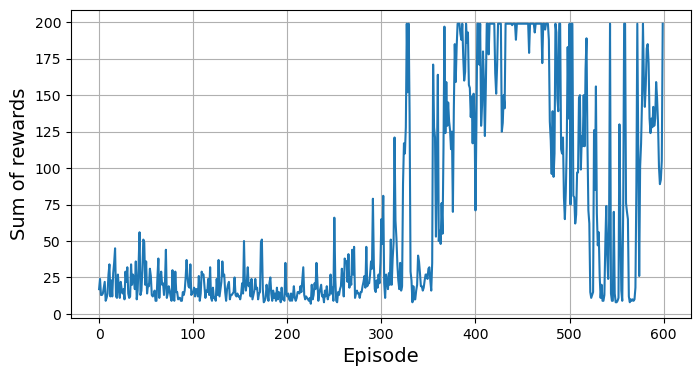

In [40]:
# 5) plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [41]:
# 2. Double DQN
# 1) The code is exactly the same as for fixed Q-Value targets
# except for the section marked as changed in the `training_step()` function:
#

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error


def training_step(batch_size):
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones, truncateds = experiences

  #################### CHANGED SECTION ####################
  # a) use the online model instead of the target model 
  # when selecting the best actions for the next states
  next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
  best_next_actions = next_Q_values.argmax(axis=1)
  next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
  
  # b) use the target model only to estimate the Q-values for these best actions
  max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                       ).sum(axis=1)
  #########################################################

  runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
  target_Q_values = rewards + runs * discount_factor * max_next_Q_values
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))


replay_buffer = deque(maxlen=2000)

for episode in range(600):
  obs, info = env.reset()
  for step in range(200):
    epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
    if done or truncated:
      break

  print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
        end="")
  rewards.append(step)
  if step >= best_score:
    best_weights = model.get_weights()
    best_score = step

  if episode > 50:
    training_step(batch_size)
    if episode % 50 == 0:
      target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 600, Steps: 66, eps: 0.0100

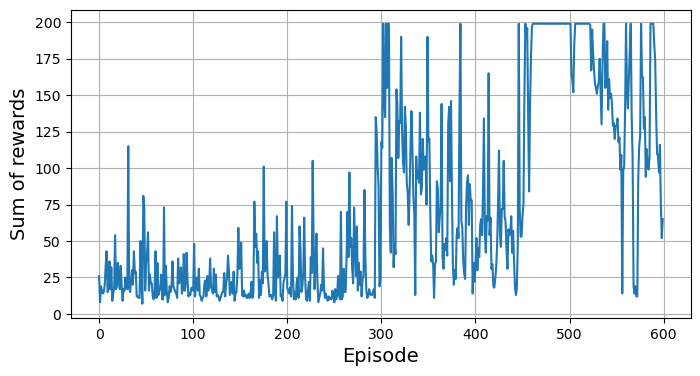

In [42]:
# 2) plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [43]:
# 3. Dueling Double DQN
# 1) build the model
input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

In [44]:
# 2) train the model

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 600, Steps: 200, eps: 0.010

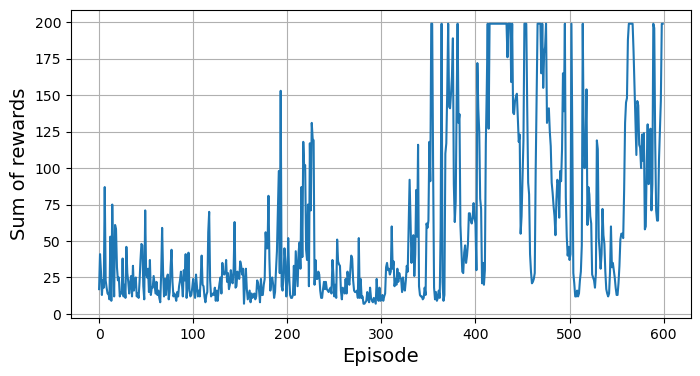

In [45]:
# 3) plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [46]:
env.close()

Overview of Some Popular RL Algorithms
---
- [AlphaGo](https://homl.info/alphago)
  - uses a variant of `Monte Carlo tree search (MCTS)` based on deep neural networks to beat human champions at the game of Go
  - MCTS selects the best move after running many simulations
    - repeatedly exploring the search tree starting from the current position
    - and spending more time on the most promising branches
  - when it reaches a node that it hasn’t visited before
    - it plays randomly until the game ends
  - and updates its estimates for each visited node (excluding the random moves)
    - increasing or decreasing each estimate depending on the final outcome
  - AlphaGo is based on the same principle
    - but it uses a policy network to select moves rather than playing randomly
    - This policy net is trained using policy gradients
  - The original algorithm involved three more neural networks and was more complicated
    - simplified in the [AlphaGo Zero paper](https://homl.info/alphagozero)
      - which uses a single neural network to both select moves and evaluate game states
      - generalized this algorithm making it capable of tackling not only the game of Go 
        - but also chess and shogi (Japanese chess)
  - [MuZero paper](https://homl.info/muzero) continued to improve upon this algorithm
    - outperforming the previous iterations 
    - even though the agent starts out without even knowing the rules of the game
- Actor-critic algorithms
  - a family of RL algorithms that combine policy gradients with deep Q-networks
  - An actor-critic agent contains two neural networks: 
    - a policy net learns differently (and much faster) than in regular PG: 
      - instead of estimating the value of each action by going through multiple episodes
      - then summing the future discounted rewards for each action
      - finally normalizing them
    - a DQN is trained normally
      - by learning from the agent’s experiences
    - the agent (actor) relies on the action values estimated by the DQN (critic)
- [Asynchronous advantage actor-critic (A3C)](https://homl.info/a3c)
  - an important actor-critic variant introduced by DeepMind researchers in 2016 
  - where multiple agents learn in parallel 
    - exploring different copies of the environment
- [Advantage actor-critic (A2C)](https://homl.info/a2c)
  - a variant of the A3C algorithm that removes the asynchronicity
  - All model updates are synchronous so gradient updates are performed over larger batches
  - which allows the model to better utilize the power of the GPU
- [Soft actor-critic (SAC)](https://homl.info/sac)
  - an actor-critic variant that learns not only rewards
    - but also to maximize the entropy of its actions
- [Proximal policy optimization (PPO)](https://homl.info/ppo)
  - based on A2C, but it clips the loss function
    - to avoid excessively large weight updates which often lead to training instabilities
- [Curiosity-based exploration](https://homl.info/curiosity)
  - The agent continuously tries to predict the outcome of its actions and seeks situations where the outcome does not match its predictions
    - In other words, it wants to be surprised
- Open-ended learning (OEL)
  - aims to train agents capable of endlessly learning new and interesting tasks 
    - typically generated procedurally
  - such as [the POET algorithm](https://homl.info/poet)
    - which generates multiple simulated 2D environments with bumps and holes and trains one agent per environment
    - the agent’s goal is to walk as fast as possible while avoiding the obstacles
  - enhanced by the [Enhanced POET paper](https://homl.info/epoet), then by the [DeepMind’s 2021 paper⁠](https://homl.info/epoet)